1. Imports and Config

In [66]:
import pathlib, datetime, itertools, random, math
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import Markdown

plt.rcParams['figure.figsize'] = (10, 6)
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 42

data_root = pathlib.Path('potato-diseases-datasets')
assert data_root.exists(), f"{data_root} does not exist, fix the path"

class_names = sorted([p.name for p in data_root.iterdir() if p.is_dir()])
num_classes = len(class_names)
Markdown(f"**Detected classes ({num_classes}):** {class_names}")


**Detected classes (7):** ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot']

2. Visual Check

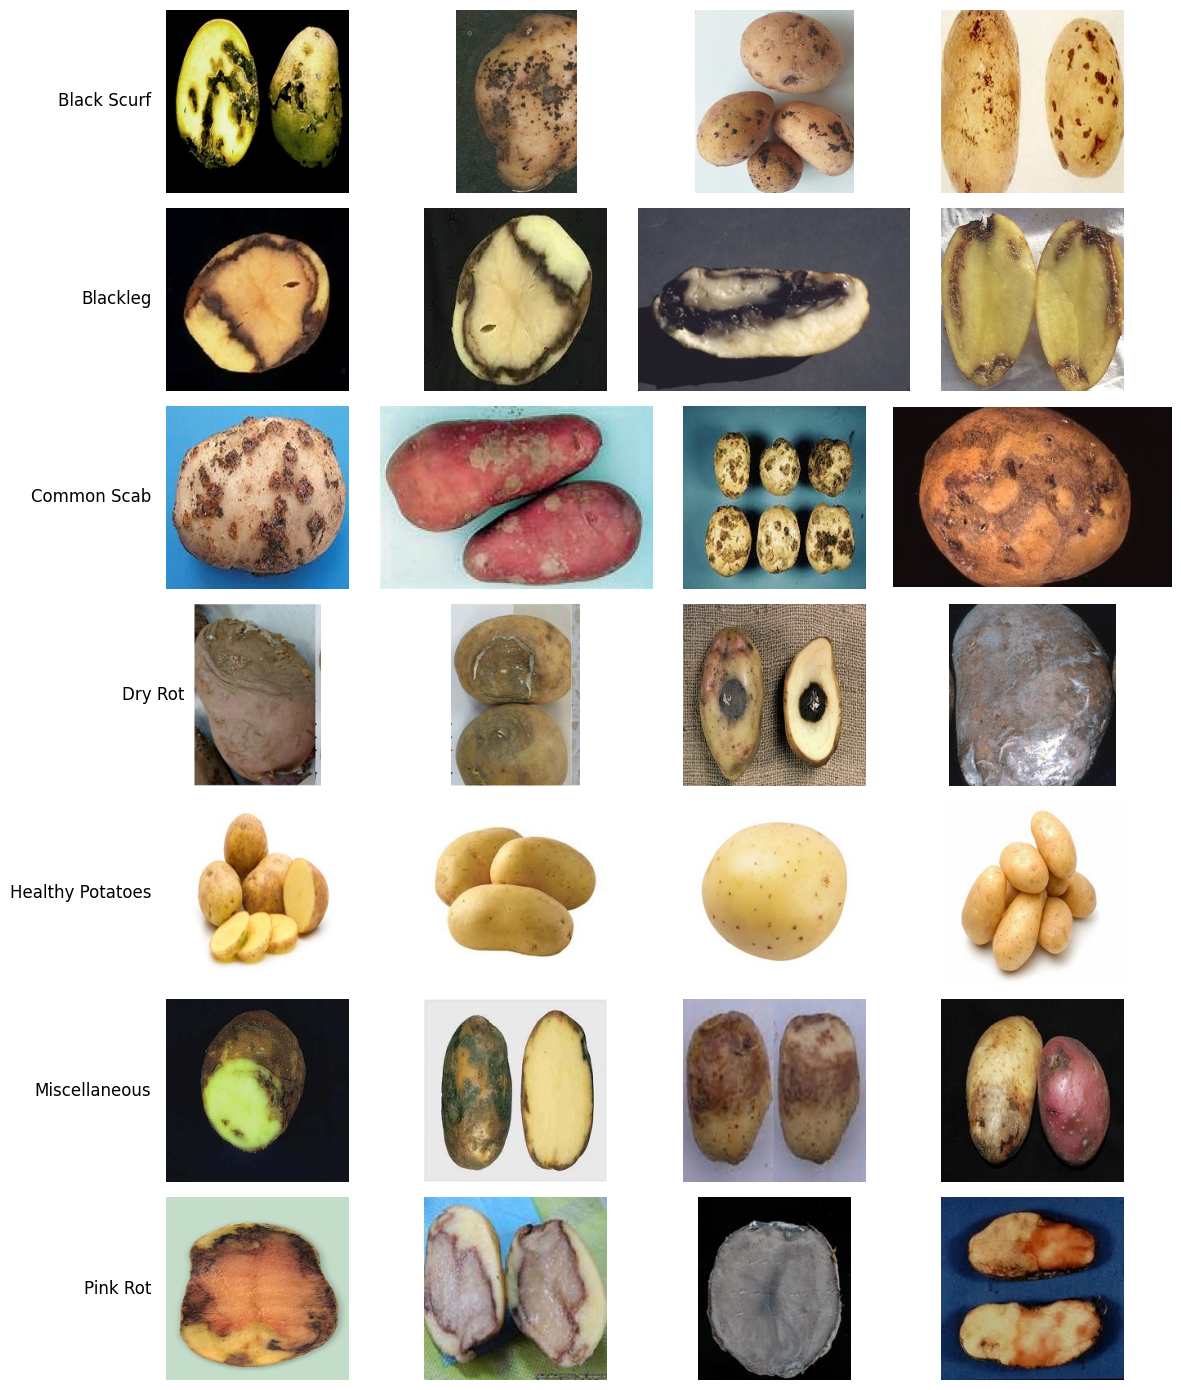

In [ ]:
def show_random_images(root, classes, n_per_class=4):
    rows = len(classes)
    fig, axes = plt.subplots(rows, n_per_class, figsize=(n_per_class*3, rows*2))
    for row, cls in enumerate(classes):
        images  = list((root/cls).glob('*'))
        chosen  = random.sample(images, k=min(n_per_class, len(images)))
        for col, img_path in enumerate(chosen):
            img = plt.imread(img_path)
            ax  = axes[row, col]
            ax.imshow(img)
            ax.axis('off')
           
            if col == 0:
                ax.text(
                    -0.08, 0.5, cls,
                    transform=ax.transAxes,
                    fontsize=12,
                    va='center',
                    ha='right'
                )
    plt.tight_layout()
    plt.show()

show_random_images(data_root, class_names, n_per_class=4)


3. Dataset Spliting

In [68]:
files, labels = [], []
for idx, cls in enumerate(class_names):
    for img in (data_root/cls).glob('*'):
        files.append(str(img))
        labels.append(idx)

files = np.array(files)
labels = np.array(labels)

train_files, tmp_files, train_lbls, tmp_lbls = train_test_split(
    files, labels, test_size=0.30, stratify=labels, random_state=RANDOM_SEED)

val_files, test_files, val_lbls, test_lbls = train_test_split(
    tmp_files, tmp_lbls, test_size=0.50, stratify=tmp_lbls, random_state=RANDOM_SEED)

def make_path_ds(paths, lbls):
    p_ds = tf.data.Dataset.from_tensor_slices(paths)
    l_ds = tf.data.Dataset.from_tensor_slices(lbls)
    return tf.data.Dataset.zip((p_ds, l_ds))

print(f"Dataset sizes  train: {len(train_files)}, val: {len(val_files)}, test: {len(test_files)}, total: {len(files)}")


Dataset sizes  train: 315, val: 68, test: 68, total: 451


4. Image distrebution per Class/Split

,class,train,val,test
0,Black Scurf,40,9,9
1,Blackleg,42,9,9
2,Common Scab,43,9,10
3,Dry Rot,42,9,9
4,Healthy Potatoes,56,12,12
5,Miscellaneous,52,11,11
6,Pink Rot,40,9,8


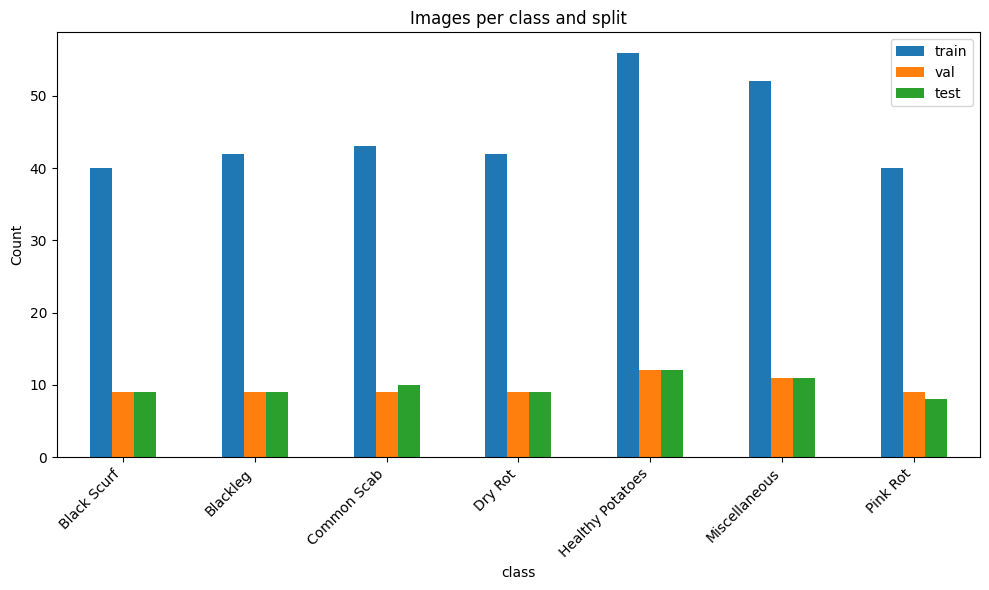

In [69]:
def counts(paths, lbls):
    s = pd.Series(lbls)
    counts = s.value_counts().sort_index()
    return counts

cnt_df = pd.DataFrame({
    'class': class_names,
    'train': counts(train_files, train_lbls).values,
    'val':   counts(val_files, val_lbls).values,
    'test':  counts(test_files, test_lbls).values
})

display(cnt_df)

cnt_df.set_index('class').plot(kind='bar')
plt.title("Images per class and split")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



5. Data Preprocessing

In [70]:
IMG_SIZE = (224, 224)
BATCH    = 32

def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)          # keep dtype uint8, range 0..255
    return img, label

train_raw = make_path_ds(train_files, train_lbls).map(decode_resize, AUTOTUNE)
val_raw   = make_path_ds(val_files,   val_lbls).map(decode_resize, AUTOTUNE)
test_raw  = make_path_ds(test_files,  test_lbls).map(decode_resize, AUTOTUNE)

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.20),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.20),
], name='augmentation')

geo_augment = tf.keras.Sequential([

], name="geo_augment")

def prep_ds(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1024, seed=RANDOM_SEED)
        ds = ds.map(lambda x, y: (augment(x, training=True), y), AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = prep_ds(train_raw, training=True)
val_ds   = prep_ds(val_raw,   training=False)
test_ds  = prep_ds(test_raw,  training=False)


6. Class Weights

In [71]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_lbls
)
class_weights = {i:w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: 1.125, 1: 1.0714285714285714, 2: 1.0465116279069768, 3: 1.0714285714285714, 4: 0.8035714285714286, 5: 0.8653846153846154, 6: 1.125}


7. Model Definition

In [72]:
def build_model():
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SIZE + (3,)
    )
    base.trainable = False                  # phase 1

    inputs  = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs, name='PotatoNet')

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "PotatoNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
___________________________________________

8. Pre Training

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        verbose=1
    )
]

history1 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1   
)


Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.9066 - accuracy: 0.2571 - val_loss: 1.7352 - val_accuracy: 0.3529 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 2s 197ms/step - loss: 1.5792 - accuracy: 0.4254 - val_loss: 1.4745 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 2s 215ms/step - loss: 1.3209 - accuracy: 0.5683 - val_loss: 1.3278 - val_accuracy: 0.5441 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 3s 343ms/step - loss: 1.1416 - accuracy: 0.6317 - val_loss: 1.2503 - val_accuracy: 0.5588 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 2s 214ms/step - loss: 1.0477 - accuracy: 0.6762 - val_loss: 1.1840 - val_accuracy: 0.5735 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 2s 213ms/step - loss: 0.9469 - accuracy: 0.6921 - val_loss: 1.1545 - val_accuracy: 0.5588 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 2s 209ms/step - loss

9. Fine Tuneing

In [ ]:
model.get_layer('efficientnetb0').trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start_epoch = len(history1.history['loss'])  
history2 = model.fit(
    train_ds,
    epochs=start_epoch + 15,      
    initial_epoch=start_epoch,   
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 18/32
10/10 [==============================] - 16s 601ms/step - loss: 0.7367 - accuracy: 0.7460 - val_loss: 1.0652 - val_accuracy: 0.6765 - lr: 1.0000e-04
Epoch 19/32
10/10 [==============================] - 4s 383ms/step - loss: 0.5166 - accuracy: 0.8190 - val_loss: 0.9867 - val_accuracy: 0.7059 - lr: 1.0000e-04
Epoch 20/32
10/10 [==============================] - 4s 415ms/step - loss: 0.4608 - accuracy: 0.8381 - val_loss: 0.9570 - val_accuracy: 0.6912 - lr: 1.0000e-04
Epoch 21/32
10/10 [==============================] - 4s 433ms/step - loss: 0.3262 - accuracy: 0.8921 - val_loss: 0.9206 - val_accuracy: 0.7647 - lr: 1.0000e-04
Epoch 22/32
10/10 [==============================] - 4s 411ms/step - loss: 0.2904 - accuracy: 0.9143 - val_loss: 0.9355 - val_accuracy: 0.7206 - lr: 1.0000e-04
Epoch 23/32
10/10 [==============================] - 4s 411ms/step - loss: 0.2545 - accuracy: 0.9048 - val_loss: 0.9605 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 24/32
10/10 [====================

10. Save Model

In [ ]:
import os

os.makedirs('checkpoints', exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

checkpoint_path = f"checkpoints/potato_net_{timestamp}.h5"
model.save_weights(checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")

Checkpoint saved to checkpoints/potato_net_20250607_133653.h5


11. Accuracy and Loss plot

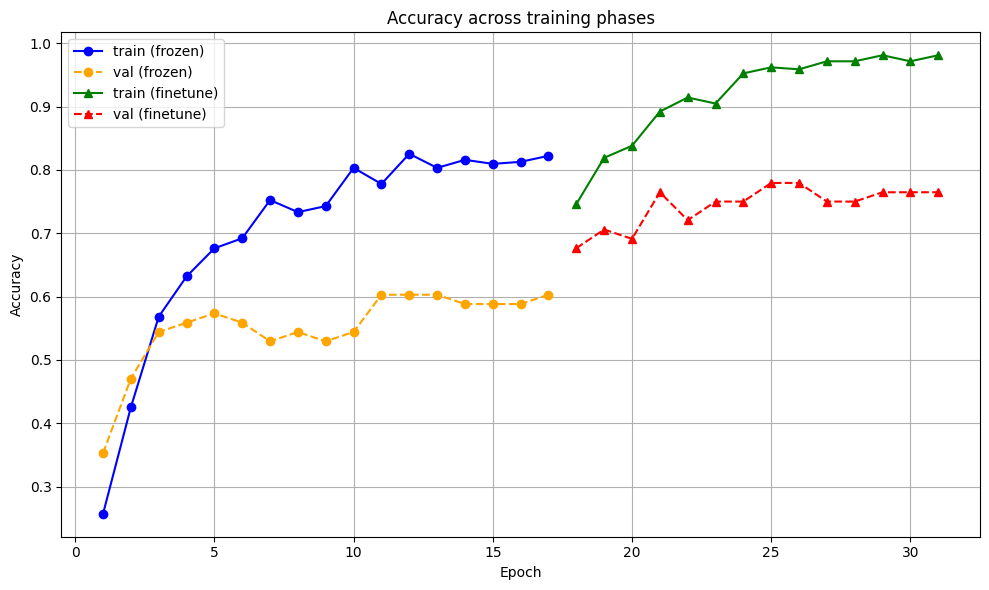

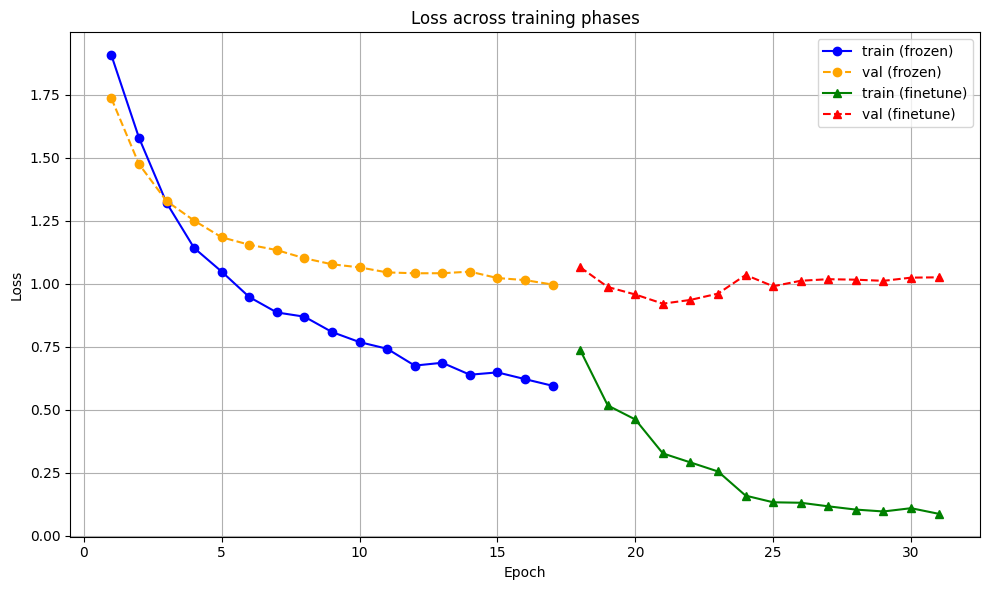

In [ ]:
def concat_histories(h1, h2):
    combined = {}
    for k in h1.history:
        combined[k] = h1.history[k] + h2.history[k]
    return combined

combined = concat_histories(history1, history2)
total_epochs = len(combined['loss'])
ft_start = len(history1.history['loss'])

epochs = list(range(1, total_epochs + 1))

def plot_with_split(metric, ylabel):
    plt.figure()

    plt.plot(
        epochs[:ft_start], combined[metric][:ft_start],
        label='train (frozen)', color='blue', marker='o', linestyle='-'
    )
    plt.plot(
        epochs[:ft_start], combined[f'val_{metric}'][:ft_start],
        label='val (frozen)', color='orange', marker='o', linestyle='--'
    )

    plt.plot(
        epochs[ft_start:], combined[metric][ft_start:],
        label='train (finetune)', color='green', marker='^', linestyle='-'
    )
    plt.plot(
        epochs[ft_start:], combined[f'val_{metric}'][ft_start:],
        label='val (finetune)', color='red', marker='^', linestyle='--'
    )

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} across training phases")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_with_split('accuracy', 'Accuracy')
plot_with_split('loss', 'Loss')


12. Model Evaluation - Confusion Matrix

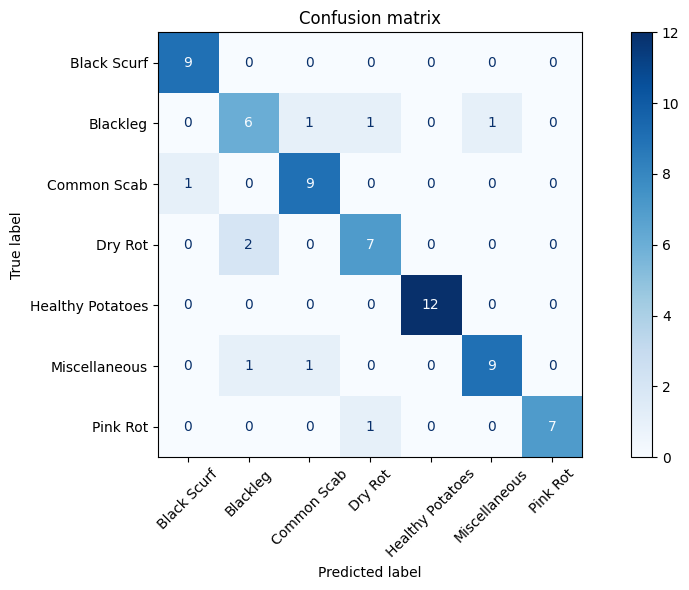


Classification report

                  precision    recall  f1-score   support

     Black Scurf       0.90      1.00      0.95         9
        Blackleg       0.67      0.67      0.67         9
     Common Scab       0.82      0.90      0.86        10
         Dry Rot       0.78      0.78      0.78         9
Healthy Potatoes       1.00      1.00      1.00        12
   Miscellaneous       0.90      0.82      0.86        11
        Pink Rot       1.00      0.88      0.93         8

        accuracy                           0.87        68
       macro avg       0.87      0.86      0.86        68
    weighted avg       0.87      0.87      0.87        68


Test accuracy: 86.765%,   test loss: 0.5227


In [77]:
test_imgs, test_lbls_arr = [], []
for imgs, lbls in test_ds:
    test_imgs.append(imgs)
    test_lbls_arr.append(lbls)
test_imgs = tf.concat(test_imgs, axis=0)
test_lbls_arr = tf.concat(test_lbls_arr, axis=0)

pred_probs  = model.predict(test_imgs, verbose=0)
pred_labels = tf.argmax(pred_probs, axis=1)

cm = confusion_matrix(test_lbls_arr, pred_labels, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()

print("\nClassification report\n")
print(classification_report(test_lbls_arr, pred_labels, target_names=class_names))

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest accuracy: {test_acc:.3%},   test loss: {test_loss:.4f}")
